# Mode-Turbulence Coupling: Numerical Analysis
# determine dTau

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

## Physical Parameters

In [2]:
# mach number Ma
Ma = 0.025 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [3]:
meandeltaT = 2*np.pi

# variables for generating F1
stdF1 = eta * Ma**2 / (2 * np.pi)
limitY1 = eta / (2 * np.pi)

# variables for generating F2 and G1
stdF2 = eta * Ma**2
limitY2 = eta 


## Calculation parameters

In [20]:
L = 1
M = 10**3
M_short = 200
N = 1
m = 10**2

# dTau is the time step for the Runge Kutta Method
def fundTau(J): 
    dTau= 2 * np.pi / J
    return dTau

# start with J = 10000 and divide by a factor of 2
J_initial = 10000
J = J_initial

Tr = K * meandeltaT

## Calculation relations

In [11]:
 Tmax = 2 * np.pi * M
# delt = N * deltaT

## Initial Conditions

In [12]:
# initial conditions A(0)=1/2*std_F2, dA/dT(0)=0
initial_dAdT = 0
initial_AT = 0

In [13]:
n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

## Functions

In [28]:
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M, dTau):
    deltaT = []
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    # ensure that deltaT is a multiple of dTau
    for i in range(M):
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    return deltaT




# Tturb adds up the delta T's
def funTturb(deltaT):
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time



# generating F1, F2, G1
def funF_k(F_k, std, limit, deltaT, Tturb):
    time = []
    y1 = 0
    for i in range(len(deltaT) - 1):
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        Ttemp = np.linspace(0, deltaT[i], deltaT[i] / dTau)
        # loops through each eddy
        for j in Ttemp:
            x = j / deltaT[i][0]
            if j == deltaT[i]:
                pass
            else:
                time.append(j+Tturb[i])
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
    return F_k, time


def funAmp(Amp, time, F1, F2, G1, dTau):
    # Runge Kutta

    # A'' = f(T, A, A') = -F1 * A' - ( 1 + G1) A + F2
    # A' = u
    # u' = f(T, A, u) = -F1 * u - ( 1 + G1) A + F2
    # A'(0) = 0

    t = 0.0
    A = Amp[0]
    u = 0
    amptime = [t]
    ratio = int(dTau/fundTau(J_initial))
    
    for i in range(0, len(time), ratio):
        m1 = u
        k1 = -(F1[i] * u) - ( 1 + G1[i] ) * A + F2[i]
        m2 = u + (dTau / 2) * k1
        t_2 = t + (dTau / 2)
        A_2 = A + (dTau / 2) * m1
        u_2 = m2
        k2 = -(F1[i] * u_2) - ( 1 + G1[i] ) * A_2 + F2[i]
        m3 = u + (dTau / 2) * k2
        t_3 = t + (dTau / 2)
        A_3 = A + (dTau / 2) * m2
        u_3 = m3
        k3 = -(F1[i] * u_3) - ( 1 + G1[i] ) * A_3 + F2[i]
        m4 = u + dTau * k3
        t_4 = t + dTau
        A_4 = A + dTau * m3
        u_4 = m4
        k4 = -(F1[i] * u_4) - ( 1 + G1[i] ) * A_4 + F2[i]
        t = t + dTau 
        A = A + (dTau / 6.) * (m1 + (2. * m2) + (2. * m3) + m4)
        u = u + (dTau / 6.) * (k1 + (2. * k2) + (2. * k3) + k4)
        Amp.append(A)
        amptime.append(t)

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    
    return Amp, amptime




# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr




# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA




# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    
    
    
# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list


def Funplots(t, g1, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, g1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('G\u2081', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()
    
def funPlotAmp(time, amp, tshort, ashort):
    plt.figure(figsize=(40,10))
    plt.plot(time, Amp, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

    #plt.figure(figsize=(40,10))
    #plt.plot(tshort, Ashort, 'k')
    #plt.xticks(fontsize=30)
    #plt.yticks(fontsize=30)
    #plt.xlabel(r'$\tau$', **axis_font)
    #plt.ylabel('Amplitude', **axis_font)
    #plt.tight_layout()
    #plt.show()

##  F1, Amplitude of mode, F2 vs. Time for all runs

### Evolution 1

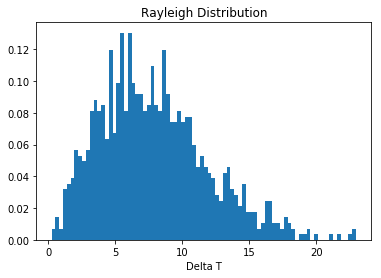

In [29]:
dTau = fundTau(J)
# where J is 10000 as defined above

deltaT = fundeltaT(n_bins, M, dTau)

Tturb, time = funTturb(deltaT)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


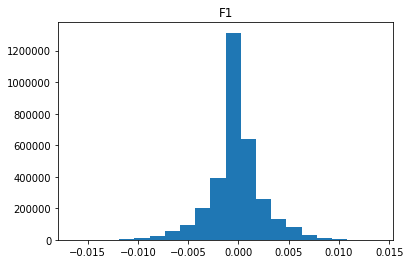

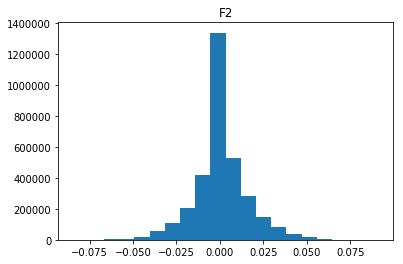

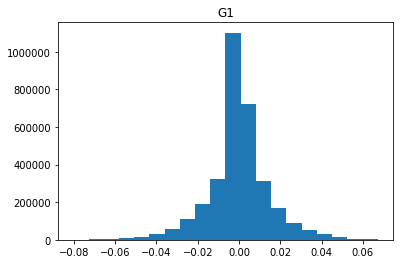

In [30]:
# generate F1

F1 = []
F1, time = funF_k(F1, stdF1, limitY1, deltaT, Tturb)

plt.hist(F1, 20)
plt.title("F1")
plt.show()

# generate F2

F2 = []
F2, time = funF_k(F2, stdF2, limitY2, deltaT, Tturb)

plt.hist(F2, 20)
plt.title("F2")
plt.show()

# generate G1

G1 = []
G1, time = funF_k(G1, stdF2, limitY2, deltaT, Tturb)

plt.hist(G1, 20)
plt.title("G1")
plt.show()

long run:


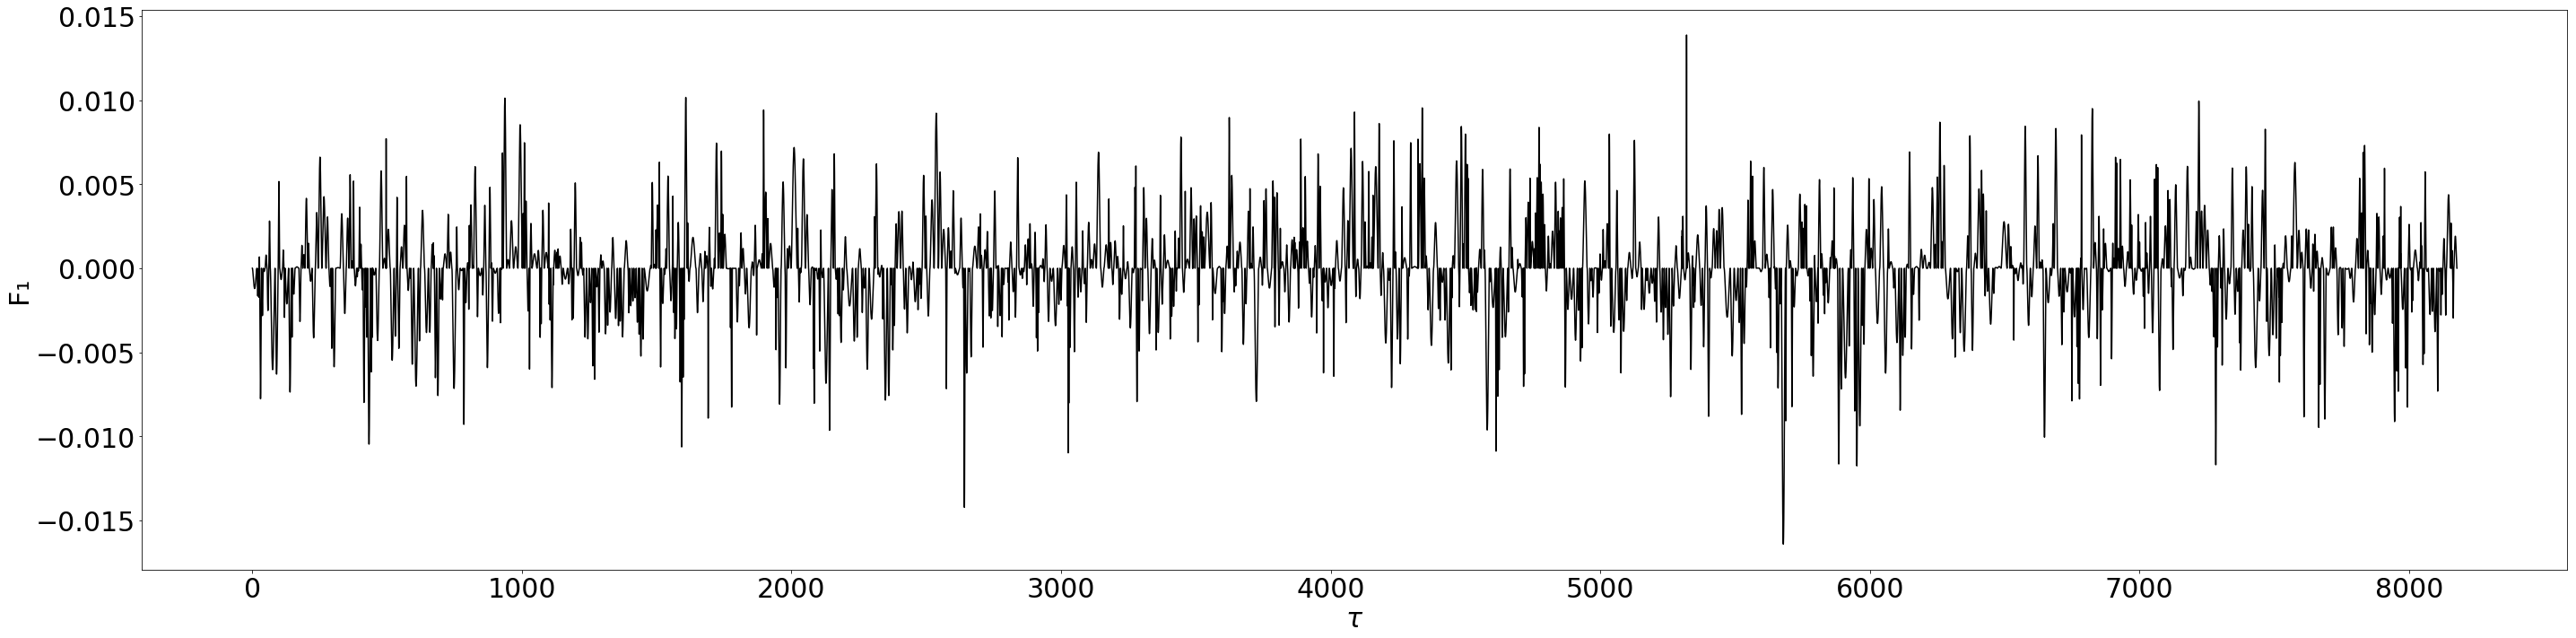

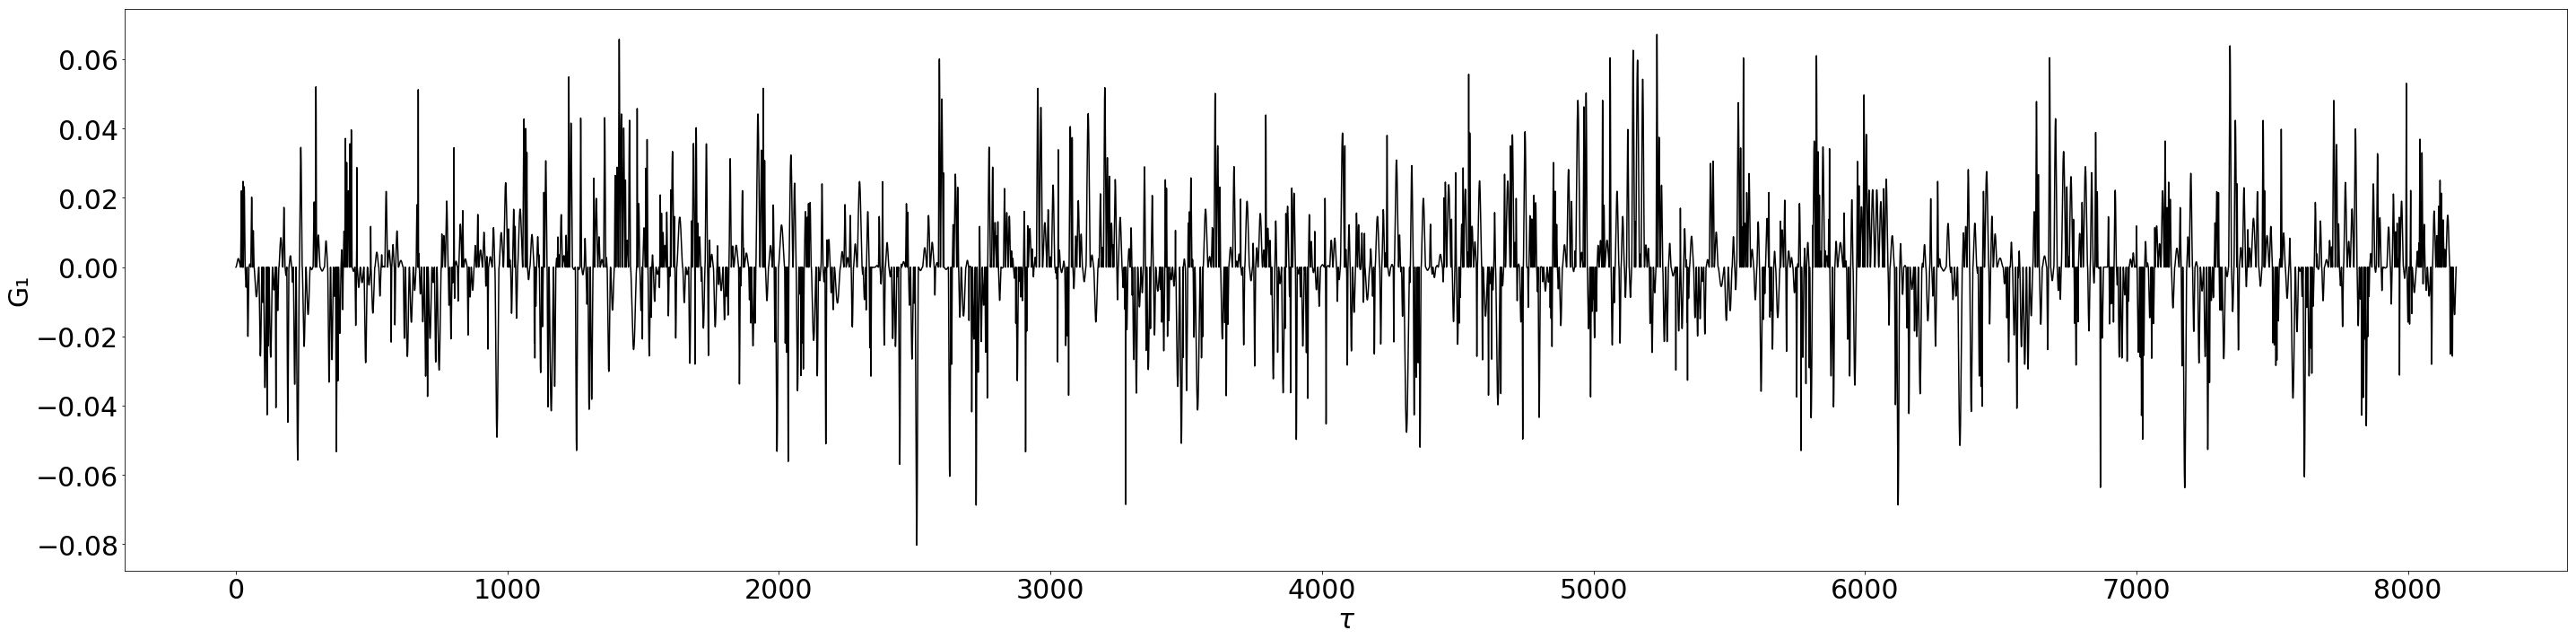

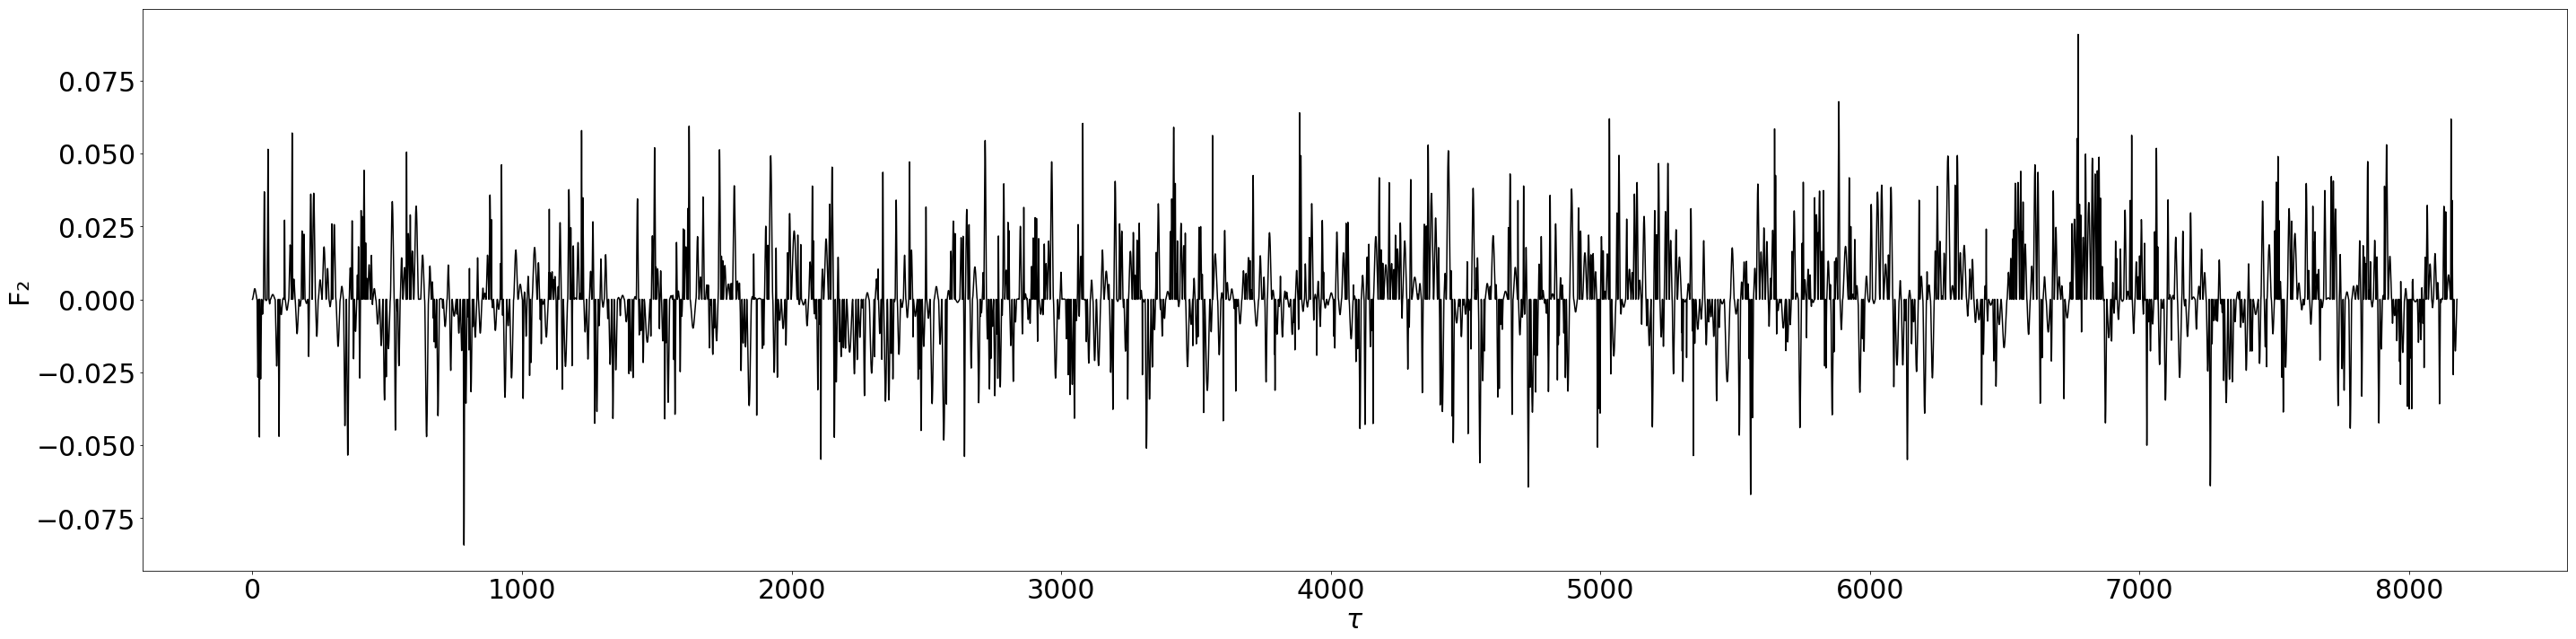

short run:


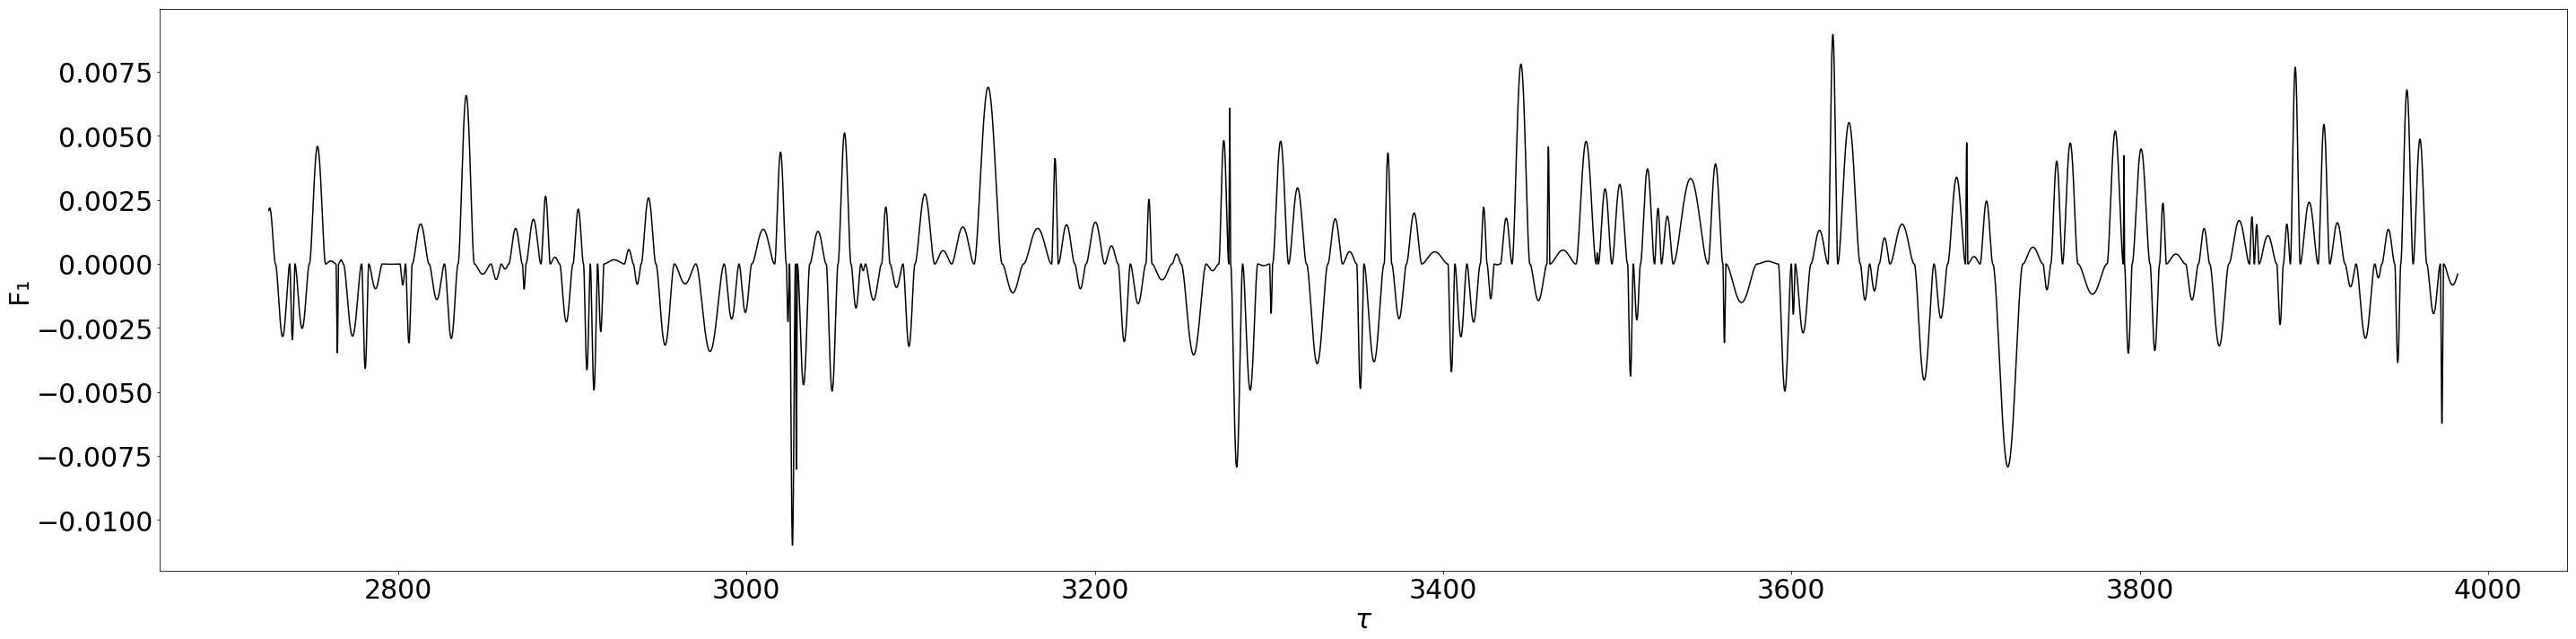

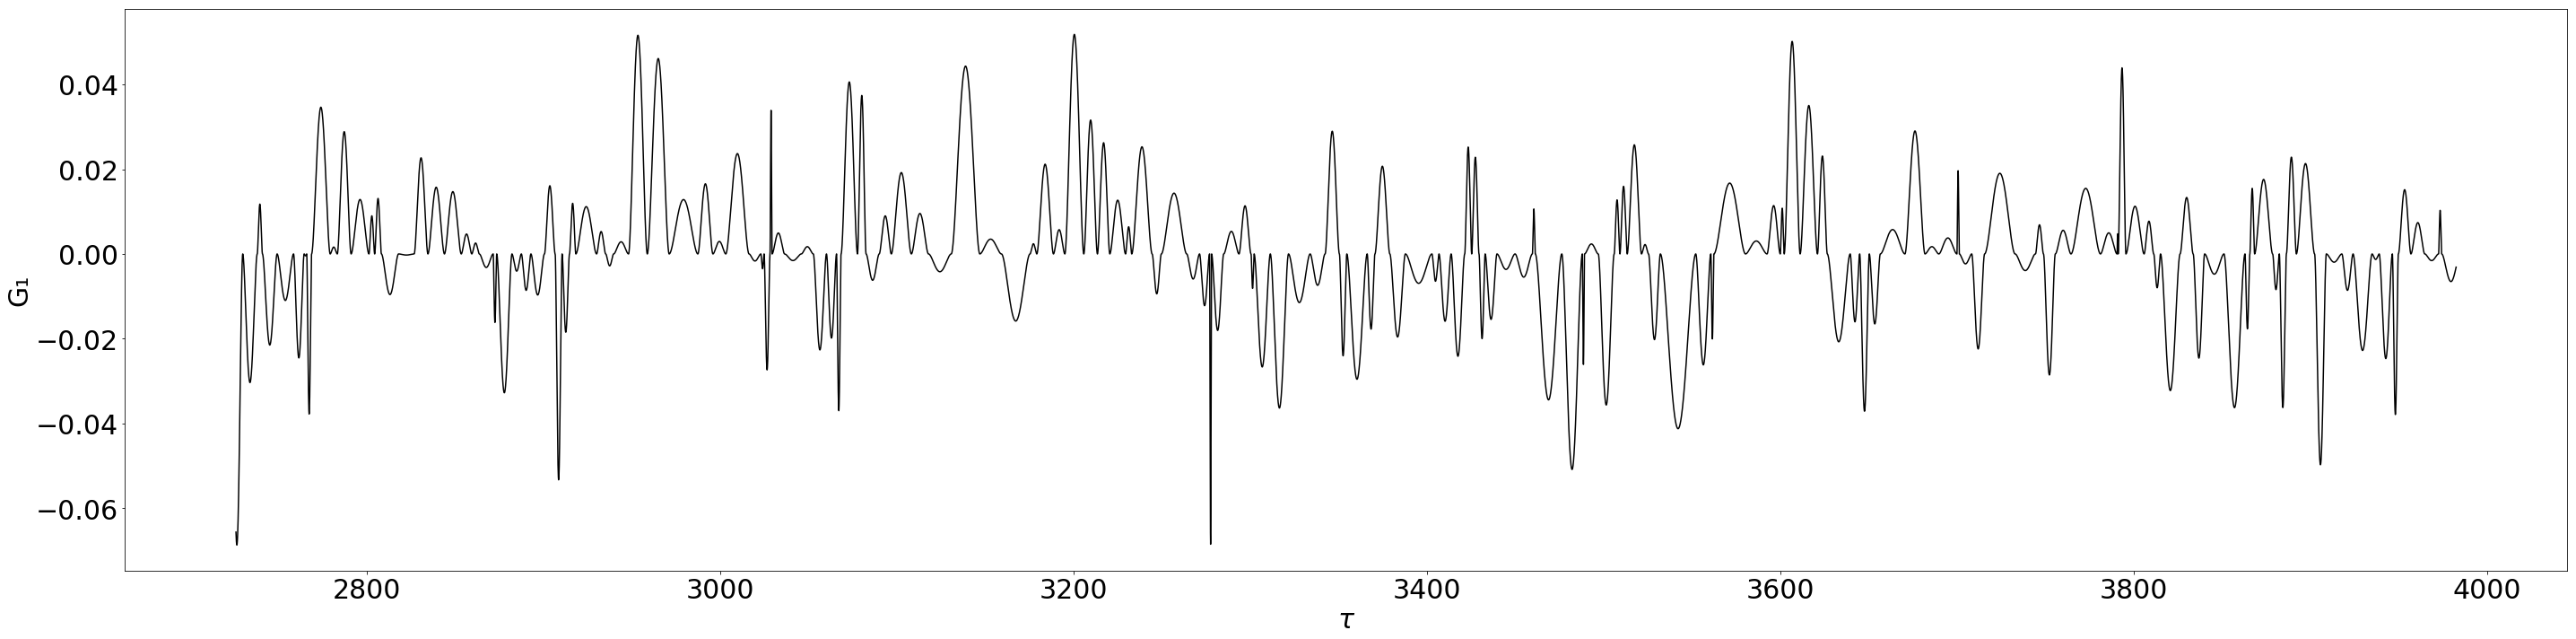

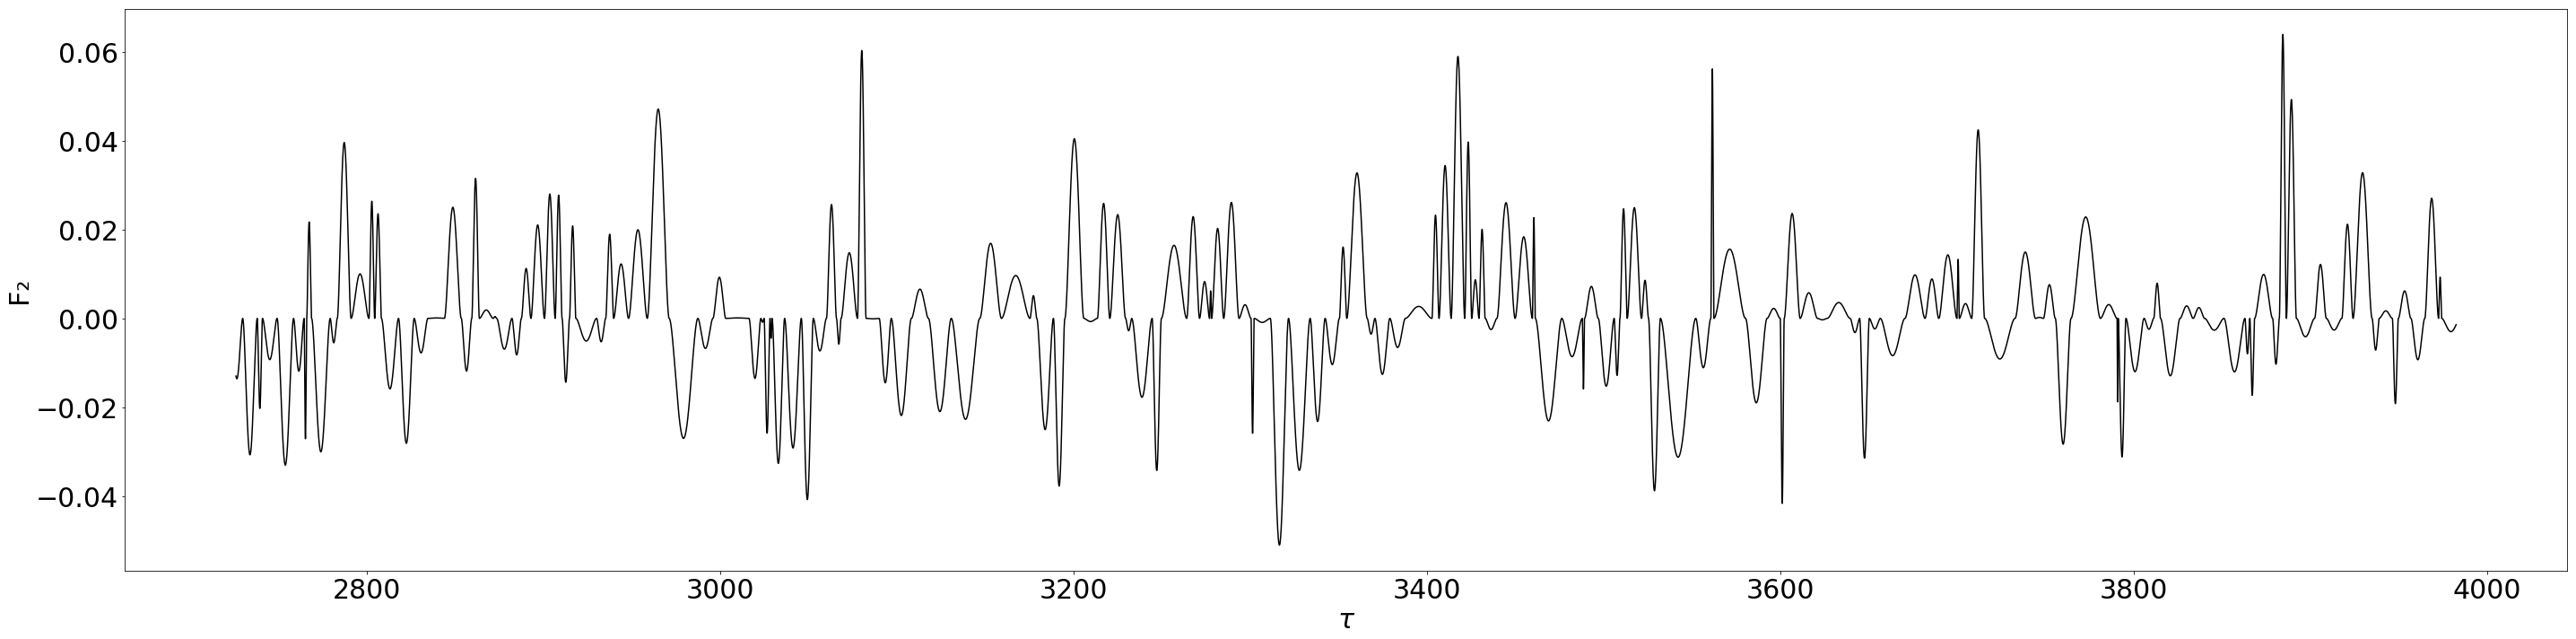

In [31]:
# plot all plots 
print ("long run:")
    
Funplots(time, G1, F1, F2)

# plot the shorter plot
duration = 2 * np.pi * M_short
tshort = []
f1short = []
f2short = []
g1short = []

# start the shorter plot a third of the way through the run
start_index = int(len(time)/3)
index = start_index
while time[index] < (duration + time[start_index]):
    tshort.append(time[index])
    f1short.append(F1[index])
    f2short.append(F2[index])
    g1short.append(G1[index])
    index +=1
    
# plot all plots
print ("short run:")
    
Funplots(tshort, g1short, f1short, f2short)

In [35]:
J = J_initial

dTau = 2 * pi / 10000


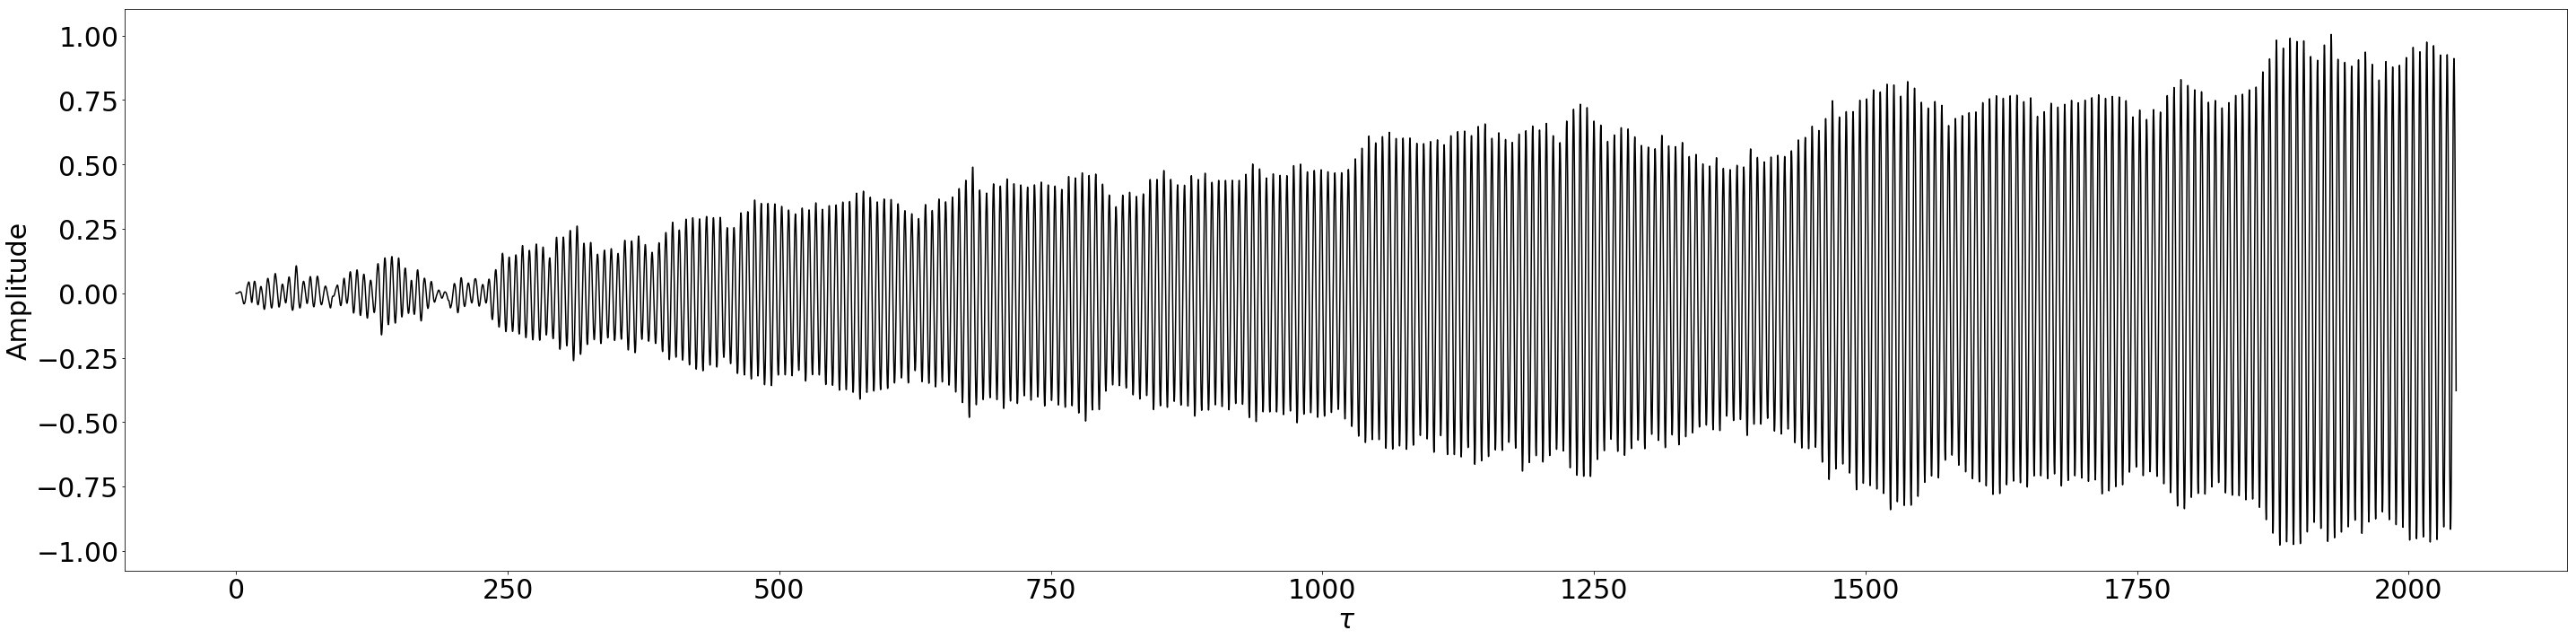

dTau = 2 * pi / 5000.0


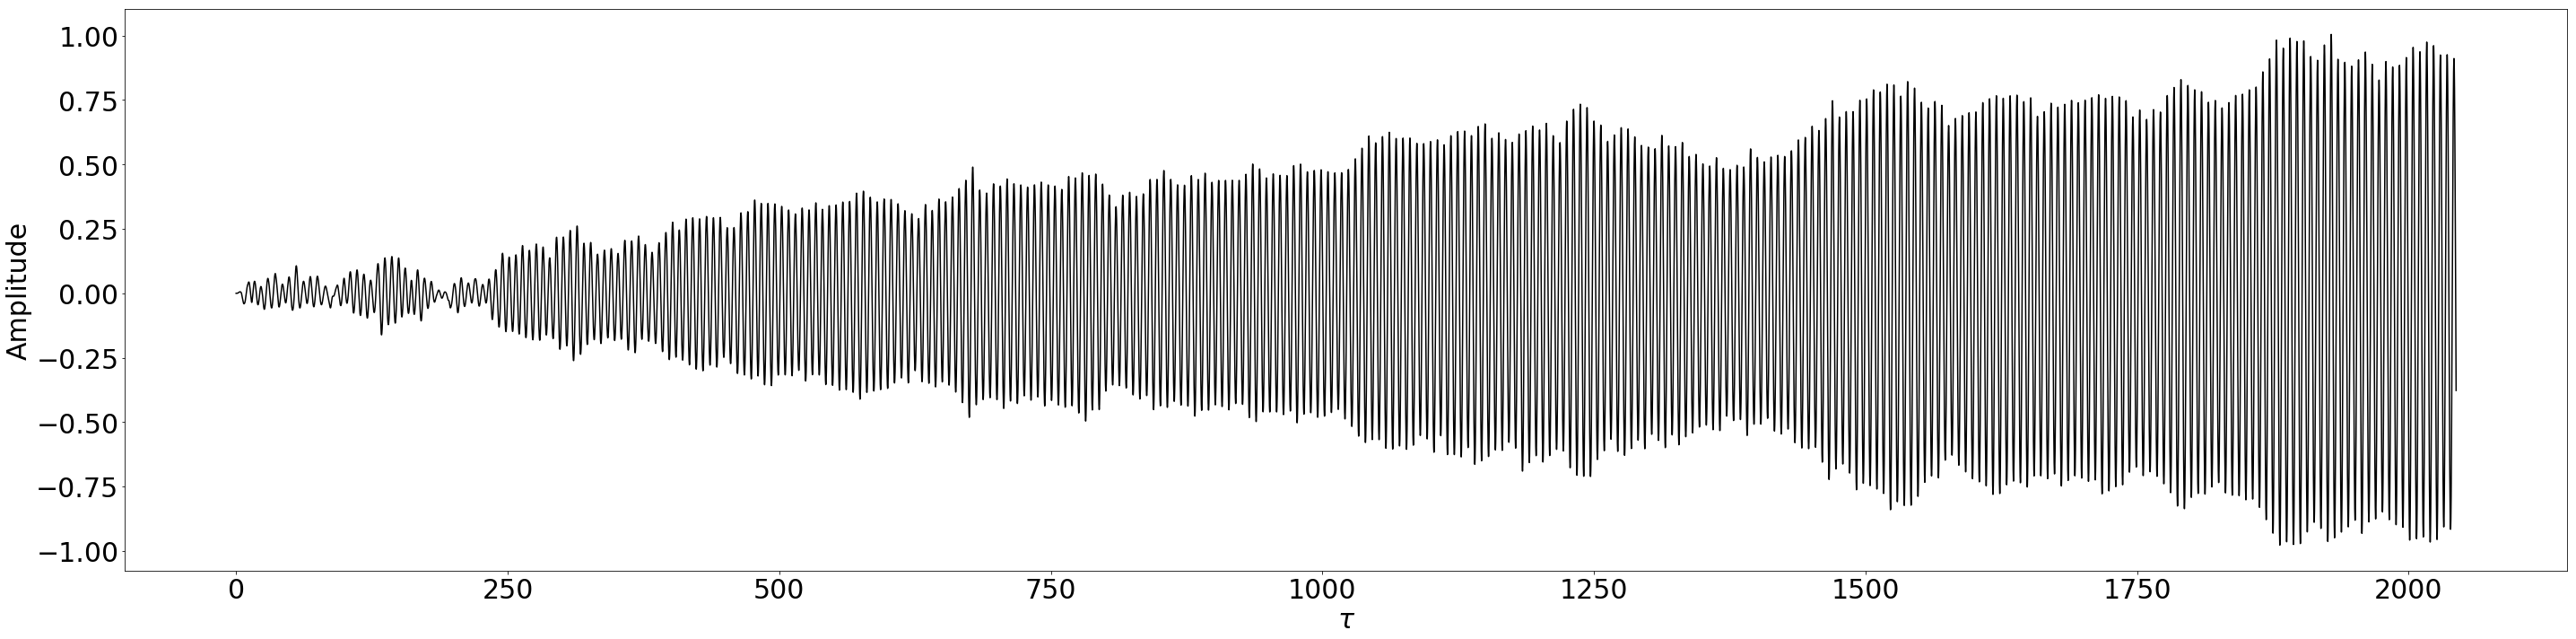

dTau = 2 * pi / 2500.0


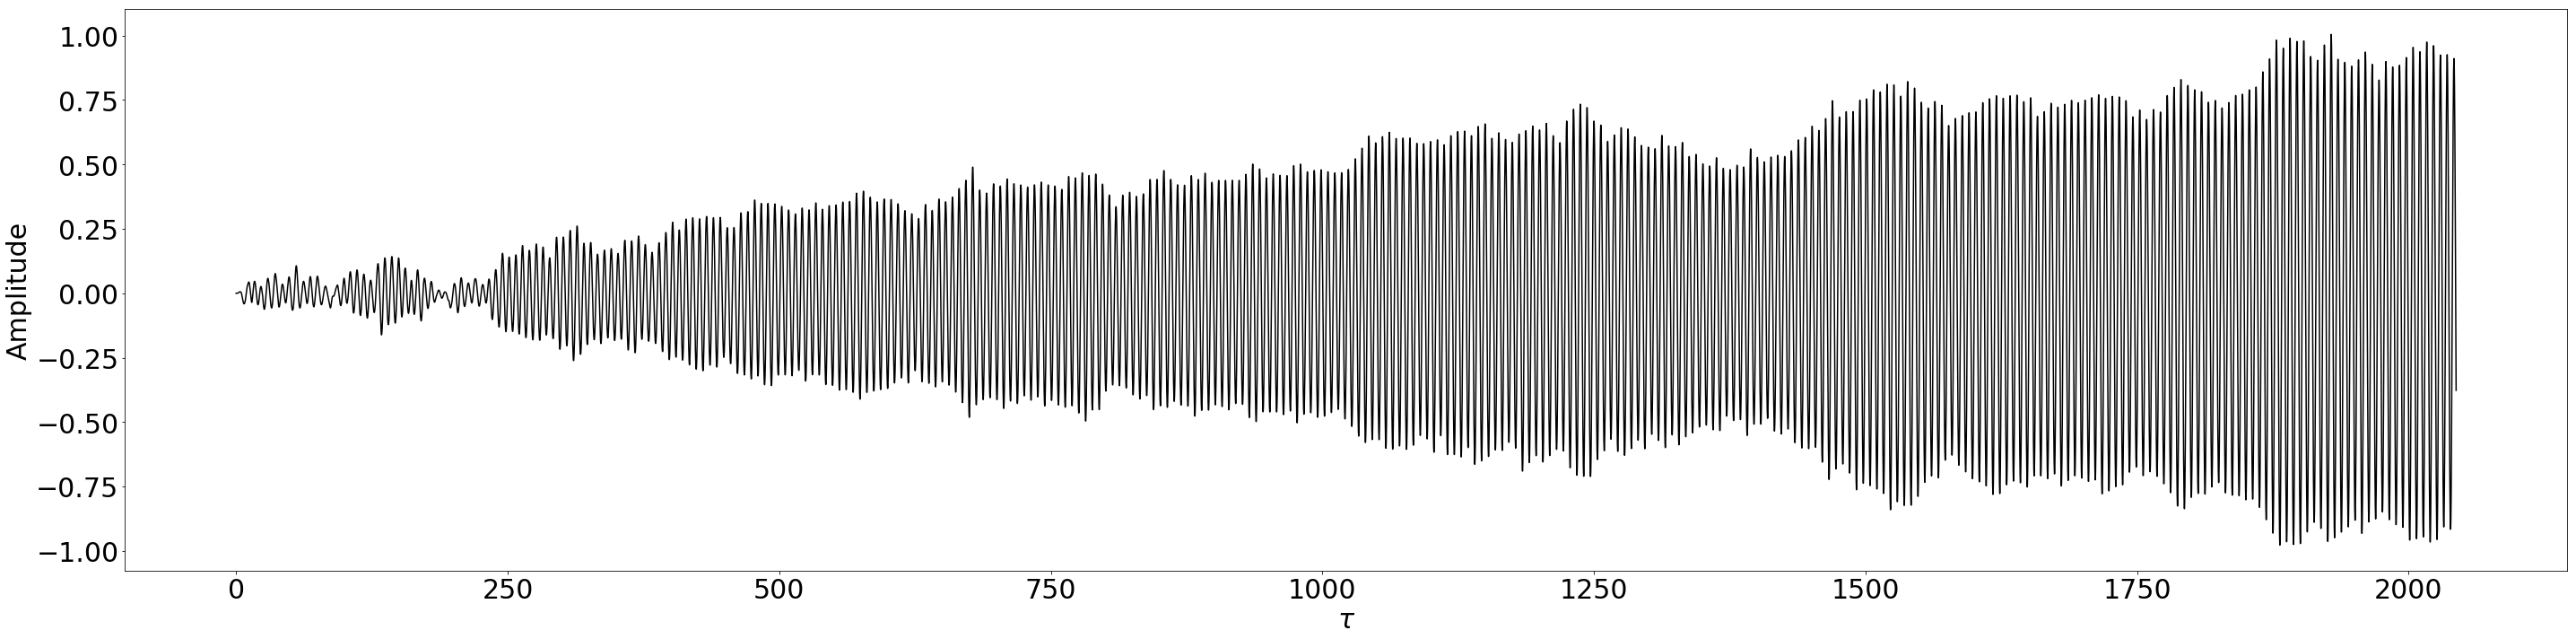

In [36]:
while J > 1250 :
    
    print("dTau = 2 * pi /", J)
    
    dTau = fundTau(J)
    
    Amp = [initial_AT]
    Amp, amptime = funAmp(Amp, time, F1, F2, G1, dTau)
    
    # shorter plot
    Ashort = []
    amptshort = []
    # start the shorter plot a third of the way through the run
    start_index = int(len(amptime)/3)
    index = start_index
    while time[index] < (duration + amptime[start_index]):
        Ashort.append(Amp[index])
        amptshort.append(amptime[index])
        index +=1

    funPlotAmp(amptime, Amp, amptshort, Ashort)
    
    J = J / 2